In [127]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [3]:
pop = pd.read_csv('data/pop_music.csv').drop('Unnamed: 0', axis=1)
print(pop.shape)
pop.head()

(36451, 22)


,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,track_id,artist_id,genre,is_pop
0,0.465,['Three Dog Night'],0.629,166707,0.376,0,0.000000,7,0.2350,-13.934,1,It Ain't Easy,26,1970-01-01,0.0337,76.848,0.347,1970,2hKxnhi2Eb3443AQbOnqNl,4FAEZeJcsYYBkNq2D3KGTV,"['album rock', 'art rock', 'blues rock', 'bril...",True
1,0.166,['Martha Reeves & The Vandellas'],0.417,176573,0.753,0,0.000000,9,0.2690,-10.204,0,I Should Be Proud,33,1970,0.1260,178.408,0.794,1970,2nxSAQBvF6gDIwZmG6B9nO,1Pe5hlKMCTULjosqZ6KanP,"['brill building pop', 'classic girl group', '...",True
2,0.840,['Roberto Luti'],0.526,158387,0.501,0,0.000000,0,0.1390,-8.088,1,Celoso,39,1970-08-28,0.0367,113.546,0.762,1970,5FD1IZKwXVSL3zGwlNvLoF,33Cme6gMFRML19GrfipNMH,['pop romantico'],True
3,0.908,['Dionne Warwick'],0.691,179040,0.157,0,0.000007,1,0.0898,-13.711,1,Raindrops Keep Falling on My Head,36,1970,0.0475,89.844,0.378,1970,5o5fCEeIGC8igGmbXQZL8Q,2JSjCHK79gdaiPWdKiNUNp,"['adult standards', 'brill building pop', 'dis...",True
4,0.908,['Johnny Mathis'],0.609,149627,0.380,0,0.001520,5,0.0728,-10.527,1,Raindrops Keep Fallin' On My Head,31,1970-02-25,0.0343,109.514,0.612,1970,6BZaceyM6nWzq0AUFcaEX1,21LGsW7bziR4Ledx7WZ1Wf,"['adult standards', 'brill building pop', 'eas...",True


# Preprocessing #

In [4]:
# create new data frame with only necessary features for modeling
pop_model = pop.drop(['artists', 'name', 'popularity', 'release_date', 'year', 'artist_id', 'genre', 'is_pop'], axis=1)
pop_model.set_index('track_id', inplace=True)
print(pop_model.shape)
pop_model.head()

(36451, 13)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
track_id,,,,,,,,,,,,,
2hKxnhi2Eb3443AQbOnqNl,0.465,0.629,166707,0.376,0,0.000000,7,0.2350,-13.934,1,0.0337,76.848,0.347
2nxSAQBvF6gDIwZmG6B9nO,0.166,0.417,176573,0.753,0,0.000000,9,0.2690,-10.204,0,0.1260,178.408,0.794
5FD1IZKwXVSL3zGwlNvLoF,0.840,0.526,158387,0.501,0,0.000000,0,0.1390,-8.088,1,0.0367,113.546,0.762
5o5fCEeIGC8igGmbXQZL8Q,0.908,0.691,179040,0.157,0,0.000007,1,0.0898,-13.711,1,0.0475,89.844,0.378
6BZaceyM6nWzq0AUFcaEX1,0.908,0.609,149627,0.380,0,0.001520,5,0.0728,-10.527,1,0.0343,109.514,0.612


In [5]:
# create list for different types of features for access later
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']
cat_features = ['explicit', 'mode', 'key']

### Using Gower Distance ###

Because the data contains a mixture of both numerical and categorical features, we will be using Gower Distance to calculate the similarity between two observations. Gower distance is on the range of 0 (identical) to 1 (maximally different). This will be very useful for including the categorical variables in the model.

In [6]:
import gower

In [7]:
# return the top 10 songs that are most similar to 'Hollaback Girl' by Gwen Stefani
sd = gower.gower_topn(pop_model.iloc[18544:18545,:], pop_model.iloc[:,:], n = 10)

# print the mean values for the features for these tracks
print(pop_model.iloc[sd['index']].describe().loc[['mean']])
# DataFrame that lists the names of these tracks
pop.iloc[sd['index']]

      acousticness  danceability  duration_ms  energy  explicit  \
mean       0.24402        0.8669     225546.3    0.82       1.0   

      instrumentalness   key  liveness  loudness  mode  speechiness     tempo  \
mean          0.000019  10.1   0.08532   -3.9557   0.0      0.14992  103.8573   

      valence  
mean   0.8087  


,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,track_id,artist_id,genre,is_pop
18544,0.3500,['Gwen Stefani'],0.926,199853,0.916,1,0.000006,10,0.0234,-2.221,0,Hollaback Girl,68,2004-11-23,0.0929,110.007,0.904,2004,0LzrhCZFXW94Y8nwtTuRlw,4yiQZ8tQPux8cPriYMWUFP,"['dance pop', 'europop', 'hip pop', 'pop', 'po...",True
18440,0.2060,['Nelly'],0.956,228240,0.745,1,0.000000,11,0.0615,-4.753,0,Hot In Herre,72,2002-06-25,0.1200,107.075,0.912,2002,04KTF78FFg8sOHC1BADqbY,2gBjLmx6zQnFGQJCAQpRgw,"['dance pop', 'hip hop', 'pop', 'pop rap', 'ra...",True
15065,0.2900,"['Clipse', 'Pharrell Williams']",0.705,261213,0.837,1,0.000000,10,0.0571,-4.640,0,I'm Good (feat. Pharrell Williams),42,2009-12-08,0.0962,82.022,0.938,2009,4dna9pp213lAcnSrbj3xGn,2J257euzcjnDLipsyJH3F2,"['alternative hip hop', 'gangster rap', 'hardc...",True
25487,0.3040,['A$AP Rocky'],0.897,187105,0.743,1,0.000044,10,0.1370,-5.446,0,Babushka Boi,74,2019-08-28,0.2220,134.979,0.905,2019,643PW82aBMUa1FiWi5VQY7,13ubrt8QOOCPljQ2FL1Kca,"['east coast hip hop', 'hip hop', 'pop rap', '...",True
19088,0.0960,"['Travis Porter', 'Tyga']",0.905,211293,0.782,1,0.000000,10,0.0623,-3.604,0,Ayy Ladies (feat. Tyga),71,2012-05-28,0.1640,96.055,0.798,2012,4P6BuLsqtg5uISdE77ypI9,6z1cicLMt9XArxN10q7m8a,"['atl hip hop', 'dirty south rap', 'pop rap', ...",True
6281,0.2510,"['Pharrell Williams', 'Kanye West']",0.845,236573,0.801,1,0.000000,10,0.0951,-5.619,0,Number One,48,2006-01-01,0.1290,107.012,0.666,2006,3r4U9UpHaFurMtq1oCZoAp,2RdwBSPQiwcmiDo9kixcl8,"['pop', 'pop rap']",True
24790,0.3510,['DMX'],0.904,244013,0.728,1,0.000137,10,0.1460,-4.773,0,How's It Goin' Down,54,2007-06-12,0.2750,90.458,0.847,2007,4tkSJRlbhuVxYjvuIQaMcj,1HwM5zlC5qNWhJtM00yXzG,"['east coast hip hop', 'gangster rap', 'hardco...",True
4902,0.2950,['Logic'],0.762,213013,0.919,1,0.000000,9,0.1260,-3.378,0,Now,52,2014-10-21,0.0690,109.971,0.603,2014,4iEWnkDewJ72copeODWuOw,4xRYI6VqpkE3UwrDrAZL8L,"['conscious hip hop', 'dmv rap', 'hip hop', 'p...",True
28733,0.2330,"['Lil Jon', 'LMFAO']",0.876,250747,0.984,1,0.000000,10,0.0505,-2.018,0,Outta Your Mind,56,2010-01-01,0.2740,99.976,0.642,2010,1Oenqmtbzt331Pgv0ODfS2,7sfl4Xt5KmfyDs2T3SVSMK,"['atl hip hop', 'crunk', 'dance pop', 'dirty s...",True
21536,0.0642,"['Calvin Harris', 'Pharrell Williams', 'Katy P...",0.893,223413,0.745,1,0.000000,11,0.0943,-3.105,0,"Feels (feat. Pharrell Williams, Katy Perry & B...",77,2017-06-30,0.0571,101.018,0.872,2017,5bcTCxgc7xVfSaMV3RuVke,7CajNmpbOovFoOoasH2HaY,"['dance pop', 'edm', 'electro house', 'house',...",True


In [8]:
# return the top 10 songs that are most similar to 'Electric Feel' by MGMT
sd = gower.gower_topn(pop_model.iloc[18717:18718,:], pop_model.iloc[:,:], n = 10)

# print the mean values for the features for these tracks
print(pop_model.iloc[sd['index']].describe().loc[['mean']])
# DataFrame that lists the names of these tracks
pop.iloc[sd['index']]

      acousticness  danceability  duration_ms  energy  explicit  \
mean      0.032594        0.7479     242834.3    0.75       0.0   

      instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
mean           0.11365  0.9    0.3143   -6.6027   1.0      0.04879  101.484   

      valence  
mean   0.5964  


,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,track_id,artist_id,genre,is_pop
18717,0.071400,['MGMT'],0.763,229640,0.807,0,0.280000,1,0.348,-3.714,1,Electric Feel,78,2007-12-14,0.0350,103.038,0.559,2007,3FtYbEfBqAlGO46NUDQSAt,0SwO7SWeDHJijQ3XNS7xEE,"['alternative dance', 'indie pop', 'indie rock...",True
27056,0.015400,['Ariana Grande'],0.725,197600,0.796,0,0.000000,1,0.354,-3.684,1,Baby I,56,2013-01-01,0.0326,101.976,0.517,2013,6EIsMa5lbvljYxqCkjZVDi,66CXWjxzNUsdJxJ2JdwvnR,"['dance pop', 'pop', 'post-teen pop']",True
27224,0.014700,['Glass Animals'],0.699,281407,0.670,0,0.220000,1,0.356,-6.219,1,Life Itself,63,2016-08-26,0.0347,111.988,0.556,2016,32zkKx35Et6A515oZKxDkD,4yvcSjfu4PC0CYQyLy4wSq,"['gauze pop', 'indietronica', 'modern rock', '...",True
21131,0.030800,"['Hot Chelle Rae', 'New Boyz']",0.742,188200,0.784,0,0.000000,1,0.354,-5.458,1,I Like It Like That (feat. New Boyz),65,2011-11-25,0.0552,101.002,0.650,2011,6eFahAdQgABBj1XOM99cBG,6jTnHxhb6cDCaCu4rdvsQ0,"['dance pop', 'neo mellow', 'neon pop punk', '...",True
2853,0.050200,['Lady Gaga'],0.752,263360,0.840,0,0.000001,1,0.227,-5.047,1,Paper Gangsta,46,2008-01-01,0.0786,98.969,0.574,2008,0LtZYj18X8mpZ2M6A7nA8t,1HY2Jd0NmPuamShAr6KMms,"['dance pop', 'pop']",True
18209,0.020200,['Sugar Ray'],0.835,244640,0.648,0,0.225000,1,0.308,-8.150,1,Fly,65,1997-06-20,0.0488,99.701,0.674,1997,3uPfVXcjnpOjyzI3jb3js4,4uN3DsfENc7dp0OLO0FEIb,"['alternative metal', 'alternative rock', 'fun...",True
26634,0.023500,['Sugar Ray'],0.836,244560,0.644,0,0.194000,1,0.297,-8.110,1,Fly,52,2005-12-20,0.0522,99.721,0.652,2005,5fuGP7Dze9tkadS9WoPbar,4uN3DsfENc7dp0OLO0FEIb,"['alternative metal', 'alternative rock', 'fun...",True
24131,0.081400,['SNAP!'],0.757,341963,0.708,0,0.206000,1,0.224,-15.232,1,"The Power - 12"" Version",52,1990,0.0455,108.928,0.554,1990,0c4s0e7Wi7EOzfjr7XNIwz,2FrKQPjJe4pVMZOgm0ESOx,"['diva house', 'eurodance', 'europop', 'german...",True
6909,0.000245,"['Ed Sheeran', 'Chris Stapleton', 'Bruno Mars']",0.631,209120,0.796,0,0.011500,1,0.380,-5.350,1,BLOW (with Chris Stapleton & Bruno Mars),69,2019-07-05,0.0401,92.469,0.596,2019,6EbduYTr62sSzvl36wWiFM,6eUKZXaKkcviH0Ku9w2n3V,"['pop', 'uk pop']",True
23123,0.018100,"['Justin Bieber', 'Jaden']",0.739,227853,0.807,0,0.000000,0,0.295,-5.063,1,Never Say Never,69,2011-01-01,0.0652,97.048,0.632,2011,5GYbkDveRD2I8M5ZJ14hWn,1uNFoZAHBGtllmzznpCI3s,"['canadian pop', 'pop', 'post-teen pop']",True


After verifying these results by listening to the tracks, gower distance is a good measure of distance to use.

### Calcuate Matrix of Similarities Between All Tracks ###

In [9]:
# create a list of cat_features indicators
cat_ind = [True if x in cat_features else False for x in pop_model.columns]

gdf = gower.gower_matrix(pop_model, cat_features=cat_ind)

In [64]:
gdf_model = pd.DataFrame(gdf, index=pop_model.index)
print(gdf_model.shape)
gdf_model.head()

(36451, 36451)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,36426,36427,36428,36429,36430,36431,36432,36433,36434,36435,36436,36437,36438,36439,36440,36441,36442,36443,36444,36445,36446,36447,36448,36449,36450
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2hKxnhi2Eb3443AQbOnqNl,0.000000,0.318137,0.190260,0.154133,0.166769,0.181071,0.200302,0.182654,0.285563,0.178499,0.179381,0.099288,0.247378,0.211589,0.275625,0.105691,0.150809,0.245769,0.269703,0.133423,0.167526,0.140402,0.220700,0.204026,0.139491,...,0.219884,0.119930,0.145708,0.201619,0.172243,0.167616,0.364336,0.316340,0.330993,0.399585,0.184455,0.248420,0.364312,0.310168,0.317192,0.278278,0.157054,0.134117,0.417235,0.187655,0.254883,0.259855,0.087099,0.192624,0.144887
2nxSAQBvF6gDIwZmG6B9nO,0.318137,0.000000,0.285791,0.376135,0.322953,0.262695,0.359025,0.297781,0.197825,0.213617,0.214328,0.322283,0.216653,0.280581,0.234321,0.268567,0.222398,0.296164,0.280324,0.267091,0.307812,0.276694,0.361751,0.230545,0.420548,...,0.231186,0.335621,0.297543,0.384401,0.268204,0.338057,0.255465,0.193491,0.291956,0.233176,0.249471,0.214301,0.270365,0.370385,0.356578,0.187212,0.305455,0.217161,0.258285,0.261984,0.296490,0.362888,0.295891,0.251158,0.292260
5FD1IZKwXVSL3zGwlNvLoF,0.190260,0.285791,0.000000,0.177559,0.121840,0.151540,0.183514,0.050899,0.260644,0.214327,0.191458,0.122024,0.232669,0.245654,0.198692,0.207400,0.199922,0.272331,0.270165,0.150099,0.183621,0.191044,0.213177,0.072795,0.238350,...,0.205210,0.206402,0.187215,0.166264,0.186243,0.194684,0.336977,0.201502,0.337658,0.362718,0.207924,0.101529,0.387745,0.299675,0.337173,0.280025,0.114712,0.235124,0.384617,0.200402,0.376386,0.230142,0.166541,0.212572,0.113681
5o5fCEeIGC8igGmbXQZL8Q,0.154133,0.376135,0.177559,0.000000,0.136289,0.217068,0.145480,0.157355,0.266697,0.236650,0.229464,0.152851,0.258652,0.222938,0.261645,0.237329,0.193632,0.215215,0.235955,0.190081,0.111255,0.185194,0.175165,0.236647,0.166942,...,0.259546,0.154454,0.172679,0.237689,0.130795,0.215111,0.389808,0.341288,0.362838,0.434126,0.225895,0.251881,0.413174,0.258192,0.317121,0.312380,0.197843,0.247111,0.378224,0.223334,0.366739,0.302505,0.195651,0.170708,0.194413
6BZaceyM6nWzq0AUFcaEX1,0.166769,0.322953,0.121840,0.136289,0.000000,0.171277,0.089381,0.125636,0.249391,0.216901,0.210000,0.107462,0.237270,0.229925,0.218925,0.199799,0.189995,0.252812,0.186970,0.168858,0.144752,0.107802,0.192878,0.181544,0.207853,...,0.222117,0.172853,0.167104,0.224464,0.180992,0.206575,0.347236,0.299211,0.339936,0.393707,0.208910,0.195790,0.406034,0.297222,0.322903,0.279194,0.180270,0.230234,0.415719,0.203587,0.377900,0.302954,0.178595,0.220434,0.191961


The result is a matrix of similarity values for all tracks in the original dataframe. This will be used to cluster the tracks. Clustering was done in another notebook on Google Cloud for the added memory and processing power. The modeling process can be found in the KMedoids_Models notebook.

# Modeling Analysis #

Below are the results of the best model from the KMedoids_Models notebook.

In [13]:
import pickle 
results = pickle.load(open("data/model_results.p", "rb"))
results

{'k': array([3, 1, 3, ..., 3, 2, 3]),
 'medoids': [33715, 31645, 25321, 16834],
 'v_ratio': 10483.229974915155,
 's_score': 0.22875765}

In [51]:
# tracks that act as the 'center' of each cluster
pop.iloc[[33715, 31645, 25321, 16834]]

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,track_id,artist_id,genre,is_pop
33715,0.0513,['98º'],0.543,205160,0.790,0,0.000004,0,0.0981,-6.145,1,Give Me Just One Night (Una Noche),43,2000-09-26,0.0491,123.631,0.655,2000,1OvjOVieEsYqGiK1T3mUv9,6V03b3Y36lolYP2orXn8mV,"['boy band', 'dance pop']",True
31645,0.2250,['Tina Turner'],0.639,240480,0.669,0,0.001170,4,0.1000,-7.574,0,Private Dancer - Single Edit,51,1991-01-01,0.0507,116.220,0.570,1991,623ZeL2lWuz5v03TVkRBZa,1zuJe6b1roixEKMOtyrEak,"['disco', 'europop', 'new wave pop', 'soft rock']",True
25321,0.1360,['Big Sean'],0.747,213693,0.704,1,0.000000,1,0.1310,-6.743,1,Jump Out The Window,67,2017-02-03,0.0986,136.936,0.494,2017,1jQsKN68yE94tMYml0wHMd,0c173mlxpT3dSFRgMO8XPh,"['detroit hip hop', 'hip hop', 'pop rap', 'rap...",True
16834,0.4980,['Gregory Alan Isakov'],0.622,210733,0.369,0,0.004570,0,0.1090,-11.152,1,Evelyn,44,2009-05-15,0.0293,114.857,0.353,2009,63XEl1dXbErfNDia83Ao3B,5sXaGoRLSpd7VeyZrLkKwt,"['indie folk', 'neo mellow', 'new americana', ...",True


## Building the Analysis DataFrame ##

In [87]:
# create dataframe with info on tracks most similar to each medoid
medoids = gdf_model.iloc[[33715, 31645, 25321, 16834]].T
medoids['cluster'] = results['k']
medoids.columns = ['medoid_0', 'medoid_1', 'medoid_2', 'medoid_3', 'cluster']
medoids.index = pop.track_id

In [88]:
temp = pop.set_index('track_id')
clusters = temp.merge(medoids, left_index=True, right_index=True)
clusters.reset_index(inplace=True)

In [89]:
# rearrange columns so its easier to read
rearrange = ['artists', 'name', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
             'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 
             'valence', 'release_date', 'year', 'medoid_0', 'medoid_1', 'medoid_2', 'medoid_3', 'cluster', 'genre', 
             'track_id', 'artist_id']
clusters = clusters[rearrange]
clusters.head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
0,['Three Dog Night'],It Ain't Easy,0.465,0.629,166707,0.376,0,0.000000,7,0.2350,-13.934,1,26,0.0337,76.848,0.347,1970-01-01,1970,0.218438,0.254809,0.278542,0.113587,3,"['album rock', 'art rock', 'blues rock', 'bril...",2hKxnhi2Eb3443AQbOnqNl,4FAEZeJcsYYBkNq2D3KGTV
1,['Martha Reeves & The Vandellas'],I Should Be Proud,0.166,0.417,176573,0.753,0,0.000000,9,0.2690,-10.204,0,33,0.1260,178.408,0.794,1970,1970,0.237460,0.175485,0.325105,0.310158,1,"['brill building pop', 'classic girl group', '...",2nxSAQBvF6gDIwZmG6B9nO,1Pe5hlKMCTULjosqZ6KanP
2,['Roberto Luti'],Celoso,0.840,0.526,158387,0.501,0,0.000000,0,0.1390,-8.088,1,39,0.0367,113.546,0.762,1970-08-28,1970,0.105862,0.246640,0.282148,0.086823,3,['pop romantico'],5FD1IZKwXVSL3zGwlNvLoF,33Cme6gMFRML19GrfipNMH
3,['Dionne Warwick'],Raindrops Keep Falling on My Head,0.908,0.691,179040,0.157,0,0.000007,1,0.0898,-13.711,1,36,0.0475,89.844,0.378,1970,1970,0.254998,0.290001,0.232987,0.151798,3,"['adult standards', 'brill building pop', 'dis...",5o5fCEeIGC8igGmbXQZL8Q,2JSjCHK79gdaiPWdKiNUNp
4,['Johnny Mathis'],Raindrops Keep Fallin' On My Head,0.908,0.609,149627,0.380,0,0.001520,5,0.0728,-10.527,1,31,0.0343,109.514,0.612,1970-02-25,1970,0.201921,0.248245,0.288763,0.138733,3,"['adult standards', 'brill building pop', 'eas...",6BZaceyM6nWzq0AUFcaEX1,21LGsW7bziR4Ledx7WZ1Wf


## Analysis ##

### Cluster Distributions ###

In [368]:
clusters.cluster.value_counts(normalize=True)

0    0.360895
1    0.273792
3    0.234507
2    0.130806
Name: cluster, dtype: float64

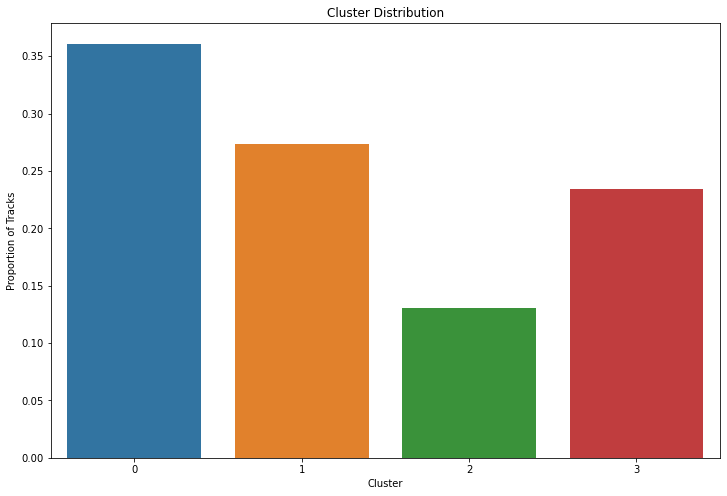

In [265]:
plt.figure(figsize=(12, 8))
sns.barplot(clusters.cluster.value_counts(normalize=True).index, clusters.cluster.value_counts(normalize=True).values)
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Tracks')
plt.show()

### Summary Statistics ###

In [307]:
# summary stats for each cluster
clusters.groupby('cluster').mean()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,medoid_0,medoid_1,medoid_2,medoid_3
cluster,,,,,,,,,,,,,,,,,,,
0,0.100383,0.572708,233445.238845,0.766330,0.010794,0.047162,4.843482,0.197943,-6.781863,0.978943,47.939339,0.062022,126.878467,0.619669,1998.602813,0.134695,0.229140,0.233429,0.195311
1,0.236311,0.599005,243991.421844,0.651231,0.093186,0.051317,6.120240,0.187652,-7.962283,0.042986,49.751904,0.077984,120.071553,0.549268,2000.049800,0.247552,0.161605,0.308258,0.270628
2,0.141332,0.697846,230578.929111,0.674185,0.917366,0.013643,4.980914,0.204457,-6.379039,0.708263,56.121644,0.177210,123.407004,0.501569,2010.156460,0.255758,0.285796,0.162722,0.290402
3,0.565823,0.532261,237279.503978,0.395711,0.014155,0.062138,4.844993,0.167972,-11.266462,0.974731,46.735611,0.046736,115.611205,0.397853,1995.299836,0.203918,0.260722,0.281639,0.146793


Key Takeaways:
- Cluster 3 is the most acoustic on average which corresponds to its lower mean energy and lower mean danceability.
- Cluster 3 tracks are the least loud and have the lowest tempo, on average.
- Cluster 3 tracks have the lowest valence on average.
- Cluster 2 tracks are more danceable, on average.
- A vast majority of Cluster 2 tracks are explicit. Additionally, Cluster 2 has the highest mean speechiness. Cluster 2 might correspond with rap tracks which are known for being explicit and have higher amounts of speech in them.
- Cluster 0 tracks have the highest mean energy and highest mean valence.
- Cluster 0 and Cluster 2 seem to contain the loudest tracks on average.
- The vast majority of Cluster 1 tracks are in minor scale

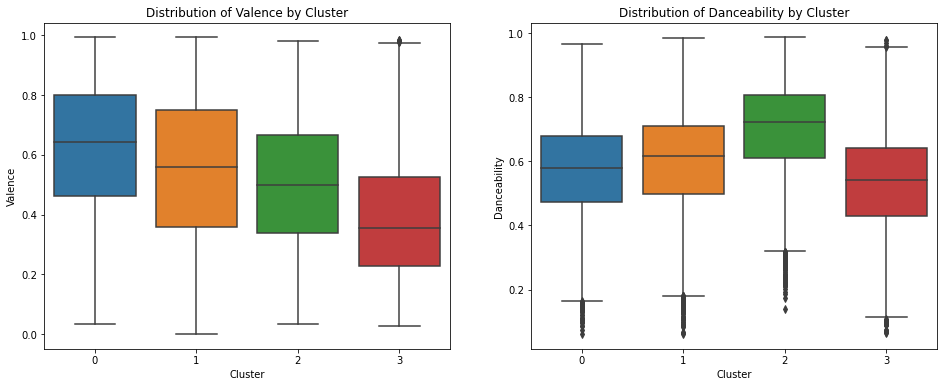

In [315]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.boxplot(clusters.cluster, clusters.valence, ax=axs[0])
axs[0].set_title('Distribution of Valence by Cluster')
axs[0].set_ylabel('Valence')
axs[0].set_xlabel('Cluster')
sns.boxplot(clusters.cluster, clusters.danceability, ax=axs[1])
axs[1].set_title('Distribution of Danceability by Cluster')
axs[1].set_ylabel('Danceability')
axs[1].set_xlabel('Cluster')
plt.show()

Mean valence decreases from Cluster 0 to Cluster 3. Mean danceability increase from Cluster 0 to Cluster 3, but Cluster 3 has the lowest mean danceability.

**Proportion of Tracks that Use Major Scale**

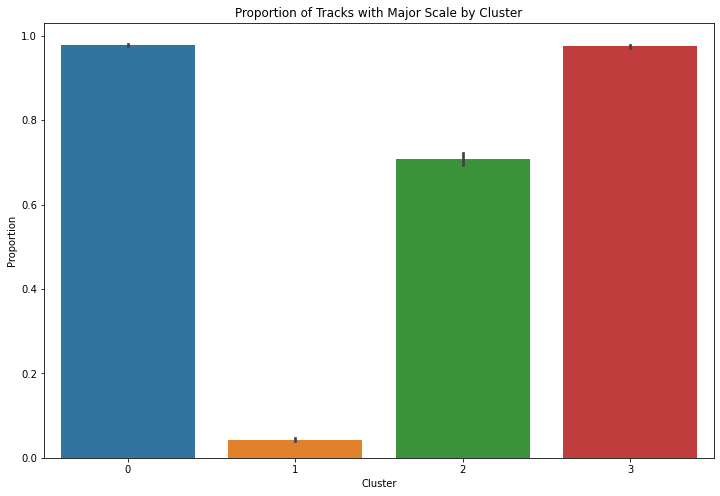

In [319]:
plt.figure(figsize=(12,8))
sns.barplot(clusters.cluster, clusters['mode'])
plt.title('Proportion of Tracks with Major Scale by Cluster')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.show()

We can see that most of the tracks in Cluster 1 employ a minor scale.

**Explict Track Proportion and Speechiness**

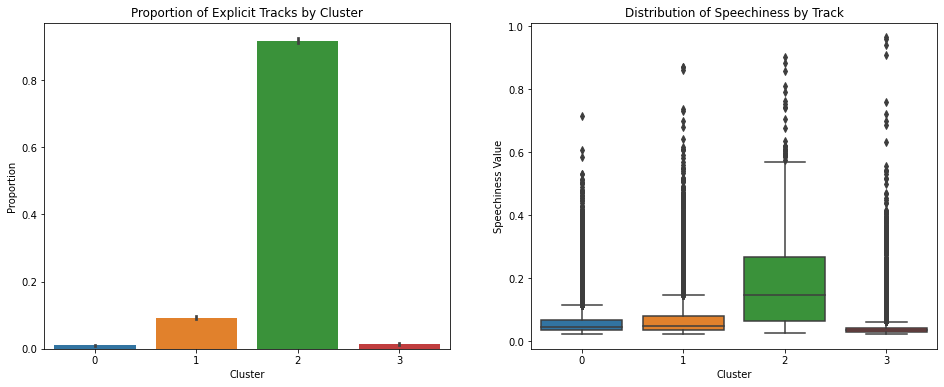

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(clusters.cluster, clusters.explicit, ax=axs[0])
axs[0].set_title('Proportion of Explicit Tracks by Cluster')
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Cluster')
sns.boxplot(clusters.cluster, clusters.speechiness, ax=axs[1])
axs[1].set_title('Distribution of Speechiness by Track')
axs[1].set_ylabel('Speechiness Value')
axs[1].set_xlabel('Cluster')
plt.show()

The combination of higher proportion of explicit tracks and higher mean speechiness shows that the tracks in Cluster 2 tend to be more rap- and hiphop-like tracks as both these genres can be characterized by their relatively high speechiness and often more explicit tracks. This is further demonstrated by the medoid for Cluster 2: Big Sean's 'Jump Out the Window.'

**Track Release Year**

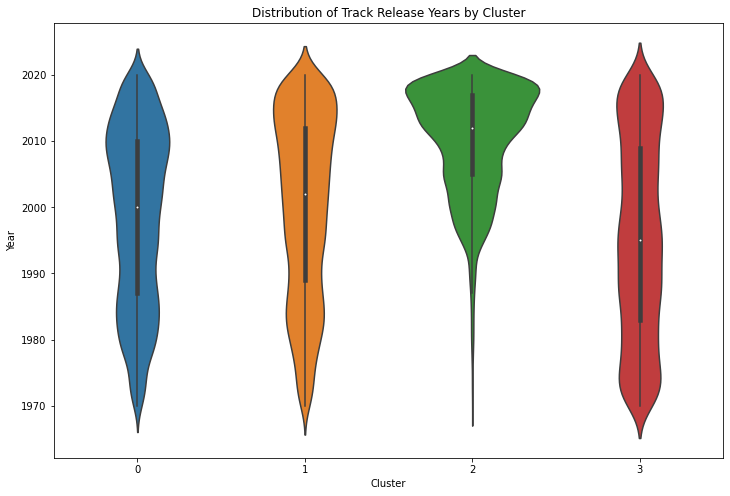

In [321]:
# track years by cluster
plt.figure(figsize=(12,8))
plt.title('Distribution of Track Release Years by Cluster')
sns.violinplot(clusters.cluster, clusters.year)
plt.ylabel('Year')
plt.xlabel('Cluster')
plt.show()

Cluster 3 tracks are evenly distributed across all years. Cluster 0 and Cluster 1 tracks are fairly evenly distributed across years however, they do have a much higher portion for track release after 2000. Cluster 2 has the newest tracks with the vast majority of them being release after 2010.

### Notable Correlations ###

In [274]:
# noteable correlations 
clusters.corr()[(clusters.corr() <= -0.5) | (clusters.corr() >= 0.5)][:15]

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster
acousticness,1.000000,NaN,NaN,-0.672385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.576448
danceability,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_ms,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy,-0.672385,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.721405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.611447
explicit,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.507928,NaN,NaN,NaN,NaN,NaN,NaN,0.510190,NaN
instrumentalness,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
key,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liveness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,NaN,NaN,NaN,0.721405,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.564534,0.578789,NaN,-0.613106,NaN


**Correlation Between Energy and Loudness of a Track**

Correlation Coeff: 0.721405


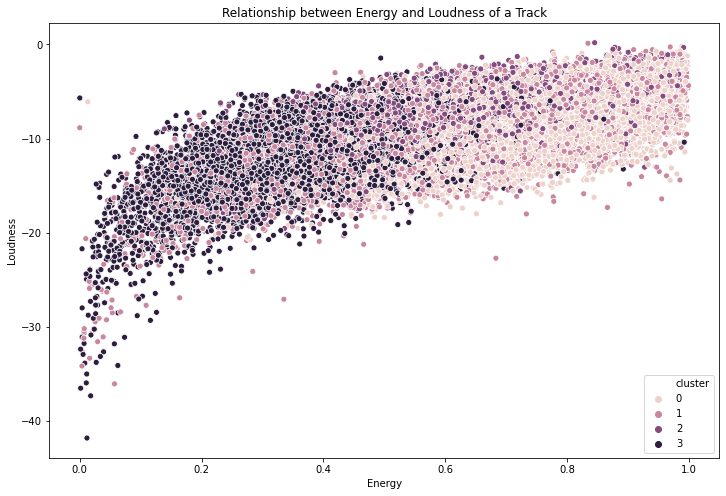

In [297]:
print('Correlation Coeff: 0.721405')
plt.figure(figsize=(12,8))
sns.scatterplot(clusters.energy, clusters.loudness, hue=clusters.cluster)
plt.title('Relationship between Energy and Loudness of a Track')
plt.ylabel('Loudness')
plt.xlabel('Energy')
plt.show()

From the above, we can see that there is a positive relationship between energy and loudness: as the energy of a track increase, it also becomes louder. We can also see that there is a clear divide in the energy and loudness between Cluster 0 and Cluster 3. Cluster 0 tracks are more loud and energetic while Cluster 3 tracks are the opposite. Clusters 1 and 2 tracks typically fall in between.  

**Correlation Between Acousticness and Energy of a Track**

Correlation Coeff: -0.672385


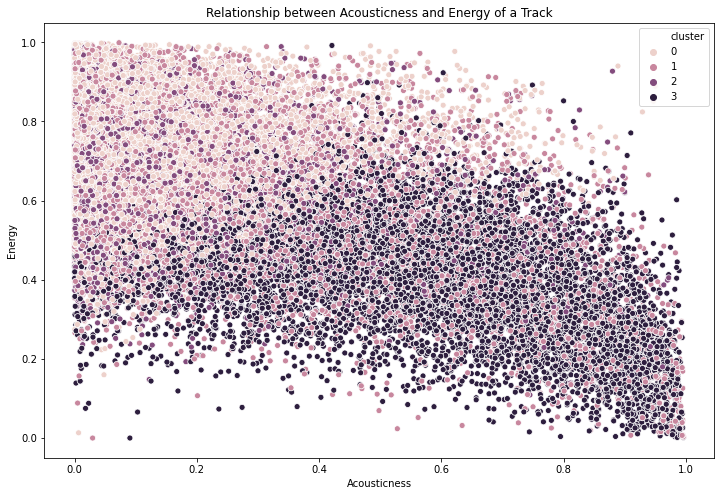

In [296]:
print('Correlation Coeff: -0.672385')
plt.figure(figsize=(12,8))
sns.scatterplot(clusters.acousticness, clusters.energy, hue=clusters.cluster)
plt.title('Relationship between Acousticness and Energy of a Track')
plt.ylabel('Energy')
plt.xlabel('Acousticness')
plt.show()

From the above plot, we can that there is a negative correlation between acoustiness and energy. As the acousticness of a track increase, its evergy tends to decrease. As seen in the previous plot, Cluster 0 and Cluster 3 are the most disparate. Cluster 3 tracks are on average more acoustic and thus less energetic, while the opposite is true for Cluster 0. Again, Clusters 1 and 2 tend to fall in between these two. 

**Correlation Between Release Year and Popularity** 

Correlation Coeff: 0.66358


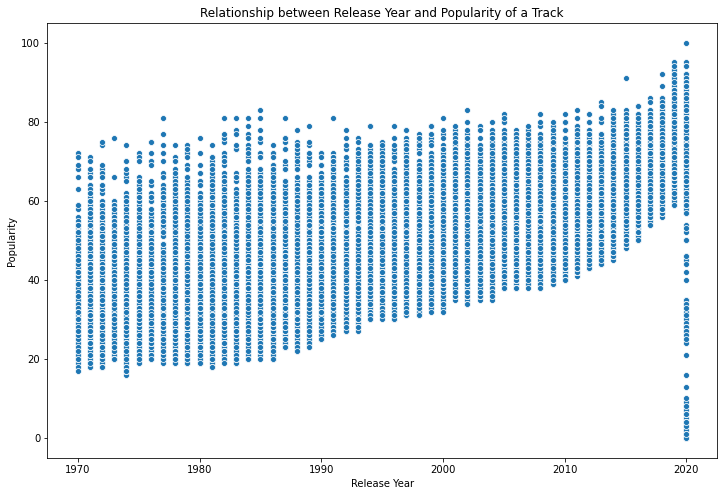

In [333]:
print('Correlation Coeff: 0.66358')
plt.figure(figsize=(12,8))
sns.scatterplot(clusters.year, clusters.popularity)
plt.title('Relationship between Release Year and Popularity of a Track')
plt.ylabel('Popularity')
plt.xlabel('Release Year')
plt.show()

From above, we can see that newly released tracks or more popular than older tracks. This doesn't really provide any iluminating information. Newly released tracks are more popular than older tracks, presumably because they are listened to at higher rates.

## Distrubtion of Genres ##

By seeing what genres are associated with each track we can get a sense of what genres are being associated together.

In [337]:
clusters.genre[1]

"['brill building pop', 'classic girl group', 'classic soul', 'motown', 'quiet storm', 'soul']"

In [338]:
# remove quotes around list
import ast
clusters.genre = clusters.genre.apply(ast.literal_eval)

In [381]:
# what genres make up cluster 0?
print('Poportion of Top 10 genres:',
      clusters[clusters.cluster == 0].explode('genre').genre.value_counts(normalize=True)[:10].sum())
clusters[clusters.cluster == 0].explode('genre').genre.value_counts(normalize=True)[:10]

Poportion of Top 10 genres: 0.27133867920987775


pop rock            0.038155
rock                0.035440
pop                 0.032563
dance pop           0.031750
dance rock          0.026008
new wave pop        0.024031
mellow gold         0.021417
soft rock           0.021367
new wave            0.021104
alternative rock    0.019503
Name: genre, dtype: float64

In [382]:
# what genres make up cluster 1?
print('Poportion of Top 10 genres:',
      clusters[clusters.cluster == 1].explode('genre').genre.value_counts(normalize=True)[:10].sum())
clusters[clusters.cluster == 1].explode('genre').genre.value_counts(normalize=True)[:10]

Poportion of Top 10 genres: 0.2437245113204894


pop                   0.044719
dance pop             0.039340
pop rap               0.023362
rock                  0.021780
pop rock              0.020514
dance rock            0.019741
new wave pop          0.019477
urban contemporary    0.018985
r&b                   0.018633
soft rock             0.017174
Name: genre, dtype: float64

Clusters 0 and 1 share 7 of the top 10 genres in each cluster. Cluster 0 differs in mellow gold, new wave, and alternative rock while Cluster 1 differs in pop rap, urban contemporary, and r&b. While they seem very similar, they do seem to capture a different secondary sound. Cluster 0 leans captures more rock-related genres while Cluster 1 captures more hip hop-related genres. Additionally, it's important to remember one of the biggest distinctions between these two clusters is that about 95% of tracks in Cluster 1 are on a minor scale while about 98% of tracks in Cluster 0 are on a major scale.

Perhaps these clusters could benefit from being divided further.

In [377]:
# what genres make up cluster 2?
print('Poportion of Top 10 genres:',
      clusters[clusters.cluster == 2].explode('genre').genre.value_counts(normalize=True)[:10].sum())
clusters[clusters.cluster == 2].explode('genre').genre.value_counts(normalize=True)[:10]

Poportion of Top 10 genres: 0.5900225056264067


pop rap             0.124381
rap                 0.106077
hip hop             0.084809
trap                0.059490
southern hip hop    0.055551
pop                 0.043998
gangster rap        0.039347
dance pop           0.035859
dirty south rap     0.021043
atl hip hop         0.019467
Name: genre, dtype: float64

Cluster 2 is by far the most distinct of the clusters and has a very strong identity. From the explicit and speechiness analysis above and the labels here, we can see that Cluster 2 is leans very strongly into rap, hip hop, trap genres. It is interesting that the smallest cluster is also the most well defined.

In [378]:
# what genres make up cluster 3?
print('Poportion of Top 10 genres:',
      clusters[clusters.cluster == 3].explode('genre').genre.value_counts(normalize=True)[:10].sum())
clusters[clusters.cluster == 3].explode('genre').genre.value_counts(normalize=True)[:10]

Poportion of Top 10 genres: 0.24014690451206716


pop             0.032361
mellow gold     0.029885
pop rock        0.027891
soft rock       0.027639
folk rock       0.023966
folk            0.021112
rock            0.020609
dance pop       0.019979
country rock    0.018657
latin pop       0.018048
Name: genre, dtype: float64

While Cluster 3 shares genres with Clusters 0 and 1, it also has a very different flavor. It is capturing more tracks that are rock-, country-, and folk-related. It is important to remember that the feature that distiguishes Cluster 3 from the other acousticness. Tracks in the cluster tend to be have lower valence and are less energetic, less danceable, and more acoustic. This can be seen with the presence of rock/country/folk genres in thi cluster.

## Tracks Present in Each Cluster ##

Below are the top ten tracks most similar to each cluster's respective medoid (the initial track used to cluster all other tracks). The first row of each dataframe below is that cluster's medoid.

**Cluster 0**

In [405]:
# top 10 tracks most similar to cluster 0 medoid
clusters[clusters.cluster==0].sort_values('medoid_0')[:10][['artists', 'name', 'medoid_0', 'cluster', 'genre']]

,artists,name,medoid_0,cluster,genre
33715,['98º'],Give Me Just One Night (Una Noche),0.000000,0,"[boy band, dance pop]"
22538,"['Bryan Adams', 'Melanie C']",When You're Gone,0.018049,0,"[album rock, canadian pop, canadian singer-son..."
1269,['Kelly Clarkson'],Stronger (What Doesn't Kill You),0.019268,0,"[dance pop, neo mellow, pop, pop rock, post-te..."
14768,['Texas'],Inner Smile,0.019855,0,"[dance pop, dance rock, europop, neo mellow, n..."
4313,['Texas'],Inner Smile,0.020198,0,"[dance pop, dance rock, europop, neo mellow, n..."
6655,['Train'],Angel in Blue Jeans,0.020585,0,"[neo mellow, pop, pop rock]"
6438,['Rob Thomas'],Mockingbird,0.020787,0,"[acoustic pop, neo mellow, pop rock]"
2184,['Cocteau Twins'],For Phoebe Still a Baby,0.021817,0,"[alternative rock, art pop, art rock, dance ro..."
19020,['Kelly Clarkson'],Stronger (What Doesn't Kill You),0.023883,0,"[dance pop, neo mellow, pop, pop rock, post-te..."
35417,['The Goo Goo Dolls'],Dizzy,0.023883,0,"[alternative rock, neo mellow, permanent wave,..."


The songs do vary greatly in genre. These songs give off a similar mood/vibe moreso than that they capture a type of genre. It's more like a mix of similar sounding songs than a cluster of songs of the same subgenre.

In [406]:
# top 10 tracks most different from cluster 0 medoid
clusters[clusters.cluster==0].sort_values('medoid_0', ascending=False)[:10][['artists', 'name', 'medoid_0', 'cluster', 'genre']]

,artists,name,medoid_0,cluster,genre
15991,['Hüsker Dü'],Dreams Reoccurring,0.310402,0,"[alternative pop, alternative rock, dance rock..."
9155,['My Bloody Valentine'],Sueisfine,0.308926,0,"[alternative rock, art pop, dream pop, indie p..."
8870,['Cheap Trick'],"Goodnight - Live at Nippon Budokan, Tokyo, JPN...",0.301797,0,"[album rock, art rock, beatlesque, classic roc..."
299,['The Replacements'],Answering Machine,0.296622,0,"[alternative pop, alternative rock, art rock, ..."
14742,['JAY-Z'],Anything,0.296414,0,"[east coast hip hop, hip hop, pop rap, rap]"
34970,['Cocteau Twins'],Musette and Drums,0.294048,0,"[alternative rock, art pop, art rock, dance ro..."
12584,['The Replacements'],Answering Machine,0.288083,0,"[alternative pop, alternative rock, art rock, ..."
10937,['My Bloody Valentine'],Several Girls Galore,0.285323,0,"[alternative rock, art pop, dream pop, indie p..."
8887,['Cheap Trick'],"Hello There - Live at Nippon Budokan, Tokyo, J...",0.285219,0,"[album rock, art rock, beatlesque, classic roc..."
27713,['Cocteau Twins'],Sugar Hiccup,0.279577,0,"[alternative rock, art pop, art rock, dance ro..."


The 10 most different songs all have a rock-related sound to them. This could be what the distribution of genres above was picking up on. This cluster definitely warrants further division. Interestingly, a JAY-Z track was clustered here. 

**Cluster 1**

In [407]:
# top 10 tracks most similar to cluster 1 medoid
clusters[clusters.cluster==1].sort_values('medoid_1')[:10][['artists', 'name', 'medoid_1', 'cluster', 'genre']]

,artists,name,medoid_1,cluster,genre
31645,['Tina Turner'],Private Dancer - Single Edit,0.000000,1,"[disco, europop, new wave pop, soft rock]"
11660,['the bird and the bee'],Witch,0.019603,1,"[indie pop, la indie]"
10844,"['オメガトライブ', 'Kiyotaka Sugiyama']",霧のDOWN TOWN,0.021346,1,[japanese city pop]
22557,['Los Enanitos Verdes'],Lamento Boliviano,0.025700,1,"[argentine rock, latin, latin alternative, lat..."
4796,['Melanie Martinez'],Seven Nation Army - The Voice Performance,0.027902,1,[pop]
11442,['The Hollies'],Bus Stop - 2003 Remaster,0.029078,1,"[album rock, art rock, brill building pop, bri..."
20069,['Depeche Mode'],Strangelove - 2006 Remaster,0.029856,1,"[dance rock, new romantic, new wave, permanent..."
18078,['Los Enanitos Verdes'],Lamento Boliviano,0.030781,1,"[argentine rock, latin, latin alternative, lat..."
1732,['Carly Pearce'],Closer To You,0.032008,1,"[contemporary country, country pop]"
31341,['Pretenders'],Private Life - 2006 Remaster,0.033215,1,"[album rock, art rock, classic rock, dance roc..."


Again, it seems that the clusters are more representative of music with the same mood/vibe. The clustering has been good at making mixes but not necessarily at clustering subgenres. Perhaps the data was inadequate to complete this task.

In [408]:
# top 10 tracks most different from cluster 1 medoid
clusters[clusters.cluster==1].sort_values('medoid_1', ascending=False)[:10][['artists', 'name', 'instrumentalness', 'medoid_1', 'cluster', 'genre']]

,artists,name,instrumentalness,medoid_1,cluster,genre
6621,['Childish Gambino'],Playing Around Before the Party Starts,0.948,0.461346,1,"[atl hip hop, hip hop, pop rap, rap]"
9638,"['John Foxx', 'Harold Budd']",Subtext,0.890,0.411431,1,"[ambient, art rock, dance rock, laboratorio, n..."
23810,['Brian Eno'],2/2 - Remastered 2004,0.947,0.407605,1,"[ambient, art pop, art rock, compositional amb..."
15834,['Jon Hassell'],Blues Nile,0.879,0.404842,1,"[ambient, art pop, art rock, avant-garde, comp..."
23814,['Brian Eno'],1/2 - Remastered 2004,0.943,0.401214,1,"[ambient, art pop, art rock, compositional amb..."
14526,['David Darling'],Darkwood 1,0.927,0.400911,1,[bow pop]
26589,['Ludovico Einaudi'],Una mattina,0.881,0.399572,1,"[bow pop, compositional ambient, neo-classical]"
33208,['Brian Eno'],Matta - Remastered 2005,0.898,0.391642,1,"[ambient, art pop, art rock, compositional amb..."
188,['Laraaji'],Meditation No. 2,0.907,0.390576,1,"[ambient, art pop, art rock, compositional amb..."
29546,"['Brian Eno', 'Harold Budd']",Above Chiangmai - 2004 Digital Remaster,0.907,0.389092,1,"[ambient, art pop, art rock, compositional amb..."


The tracks that are most different are all instrumental, ambient songs. Interestingly, a few artists show up more than once like Brian Eno and Harold Budd.

**Cluster 2**

In [409]:
# top 10 tracks most similar to cluster 2 medoid
clusters[clusters.cluster==2].sort_values('medoid_2')[:10][['artists', 'name', 'medoid_2', 'cluster', 'genre']]

,artists,name,medoid_2,cluster,genre
25321,['Big Sean'],Jump Out The Window,0.000000,2,"[detroit hip hop, hip hop, pop rap, rap, south..."
28901,"['B.o.B', 'T.I.', 'Juicy J']",We Still in this Bitch (feat. T.I. and Juicy J),0.027749,2,"[atl hip hop, dance pop, hip hop, pop, pop rap..."
3134,['Rittz'],Turn Down,0.029142,2,"[atl hip hop, country rap, pop rap, southern h..."
4561,"['Fabolous', 'T-Pain']",Baby Don't Go,0.030165,2,"[dance pop, gangster rap, hip hop, hip pop, po..."
15154,"['Wale', 'Kid Cudi']",Focused (feat. Kid Cudi),0.032347,2,"[dance pop, gangster rap, hip hop, pop, pop ra..."
4918,"['Sammy Adams', 'B.o.B']",All Night Longer REMIX (feat. B.o.B),0.033606,2,"[indie pop rap, pop rap]"
10275,['Young Thug'],Memo,0.034395,2,"[atl hip hop, atl trap, gangster rap, melodic ..."
21372,"['Chris Brown', 'Usher', 'Rick Ross']",New Flame (feat. Usher & Rick Ross),0.034496,2,"[dance pop, pop, pop rap, r&b, rap]"
25450,"['Cardi B', 'Bruno Mars']",Please Me,0.034678,2,"[pop, pop rap, rap]"
34329,"['K CAMP', 'Kwony Ca$h']",Money Baby,0.034931,2,"[atl hip hop, hip hop, melodic rap, pop r&b, p..."


This cluster is perhaps the best at capturing a distint genre as we saw in the genre distributions above.

In [411]:
# top 10 tracks most different from cluster 2 medoid
clusters[clusters.cluster==2].sort_values('medoid_2', ascending=False)[:10][['artists', 'name', 'medoid_2', 'cluster', 'genre']]

,artists,name,medoid_2,cluster,genre
13413,"['Drake', 'Chilly Gonzales']",Outro (feat. Chilly Gonzales),0.381589,2,"[canadian hip hop, canadian pop, hip hop, pop ..."
9358,['The Smashing Pumpkins'],Tales Of A Scorched Earth - Remastered 2012,0.343111,2,"[alternative metal, alternative rock, grunge, ..."
12985,['AFI'],A Single Second,0.333453,2,"[alternative metal, emo, pop punk, punk, screa..."
1128,['Drake'],The Calm,0.333384,2,"[canadian hip hop, canadian pop, hip hop, pop ..."
3993,['Too $hort'],City of Dope,0.329625,2,"[cali rap, gangster rap, hip hop, hyphy, oakla..."
10655,['Patti Smith'],Babelogue,0.328200,2,"[art pop, art punk, art rock, dance rock, folk..."
6601,['Childish Gambino'],Dial Up,0.324435,2,"[atl hip hop, hip hop, pop rap, rap]"
13405,['Bo Burnham'],My Whole Family... (live),0.324257,2,"[antiviral pop, comedy, comic]"
6575,['Nipsey Hussle'],Crenshaw & Slauson (True Story),0.322106,2,"[conscious hip hop, gangster rap, hip hop, pop..."
14306,['The Jesus and Mary Chain'],Taste the Floor,0.320661,2,"[alternative rock, art rock, dance rock, new w..."


Tracks most different from are either rock-related tracks, hip-hop songs that are on the quieter, slower side (not as hard as the top 10 tracks), or tracks that are very speechy but not rap (Babelogue, My Whole Family...(live)).

In [412]:
# top 10 tracks most similar to cluster 3 medoid
clusters[clusters.cluster==3].sort_values('medoid_3')[:10][['artists', 'name', 'medoid_3', 'cluster', 'genre']]

,artists,name,medoid_3,cluster,genre
16834,['Gregory Alan Isakov'],Evelyn,0.000000,3,"[indie folk, neo mellow, new americana, pop fo..."
20995,['Ray LaMontagne'],Let It Be Me,0.022032,3,"[acoustic pop, indie folk, neo mellow, new ame..."
12393,['Kate Bush'],Symphony in Blue,0.023552,3,"[art pop, art rock, baroque pop, dance rock, n..."
23717,['Jackson Browne'],For a Dancer - 2014 Remaster,0.025277,3,"[album rock, classic rock, country rock, folk,..."
29544,"['Andy Gibb', 'Olivia Newton-John']",I Can't Help It,0.025360,3,"[adult standards, bubblegum pop, disco, mellow..."
36189,"['Iron & Wine', 'Ben Bridwell']",This Must Be The Place,0.025519,3,"[acoustic pop, indie folk, indie pop, neo mell..."
1385,['The Story So Far'],Navy Blue,0.026880,3,"[alternative emo, anthem emo, emo, pop punk]"
25703,['Firefall'],Strange Way,0.026937,3,"[album rock, bubblegum pop, classic rock, coun..."
926,['The Format'],On Your Porch,0.027750,3,[indie pop]
7166,['Eddie Rabbitt'],Kentucky Rain - 2008 Version,0.028232,3,"[classic country pop, country, country rock, m..."


The most similar song are very slow and use a lot of acoustic instruments. They are ballads or sadder songs.

In [414]:
# top 10 tracks most different from cluster 3 medoid
clusters[clusters.cluster==3].sort_values('medoid_3', ascending=False)[:10][['artists', 'name', 'instrumentalness', 'medoid_3', 'cluster', 'genre']]

,artists,name,instrumentalness,medoid_3,cluster,genre
29443,['Brian Eno'],Discreet Music - Remastered 2004,0.939,0.384449,3,"[ambient, art pop, art rock, compositional amb..."
19935,['Brian Eno'],Signals - Remastered 2005,0.944,0.359370,3,"[ambient, art pop, art rock, compositional amb..."
15882,['Penguin Cafe Orchestra'],Harmonic Necklace - 2008 Digital Remaster,0.891,0.346315,3,"[bow pop, compositional ambient]"
23935,['Brian Eno'],Stars - Remastered 2005,0.932,0.341281,3,"[ambient, art pop, art rock, compositional amb..."
31419,['Brian Eno'],The Secret Place - Remastered 2005,0.894,0.339051,3,"[ambient, art pop, art rock, compositional amb..."
4415,['William Basinski'],Melancholia II,0.928,0.337329,3,"[ambient, art pop, compositional ambient, drif..."
21904,['Brian Eno'],1/1 - Remastered 2004,0.913,0.336296,3,"[ambient, art pop, art rock, compositional amb..."
31340,"['Brian Eno', 'Harold Budd']",Among Fields Of Crystal - 2004 Digital Remaster,0.876,0.331465,3,"[ambient, art pop, art rock, compositional amb..."
33106,['Laraaji'],Meditation No. 1,0.888,0.326436,3,"[ambient, art pop, art rock, compositional amb..."
27698,['Brian Eno'],A Clearing - Remastered 2004,0.970,0.324766,3,"[ambient, art pop, art rock, compositional amb..."


Again, similar to the most different tracks of Cluster 1, the tracks that are the most different are instrumental, ambient tracks. 

# Conclusions #

All cluster are very good at identify a certain feeling, mood, or vibe of a track. They also do decent job identifying subgenres of different kinds of music (rock, rap, pop, etc). Mostly, however, the cluster are producing good songs mixes of similar sounding and feeling tracks. I beginning to suspect that the data I am using may be inadequate for the task of classifying subgenres of pop music.

Nonetheless, it is worth continuing on this current path. The next step will be to further divide each cluster and see if more subgenres can be identified or, at the very least, more interesting track mixes. 

In [422]:
# export csv
clusters.to_csv('data/clusters.csv')